# 最尤推定によるバネの特性計測

今回は，最尤推定の例題としてバネの特性を計測する問題を取り上げ，どのように特性の推定が行われるかについて確認してみます．


# 0. 今回利用する Python の機能（興味がなければ1まで飛ばして問題ありません）

本題に入る前に，今回利用する Python の機能について説明しておきます．今回は行列の掛け算，逆行列，$\exp(x)$の計算，$\Pi_{i=1}^N x_i$の計算，乱数の生成が必要になります．また，関数という機能を利用しますので，利用方法を説明します（興味がない場合は飛ばしてください）

これらの機能は numpy と呼ばれるモジュールにより提供されます．まずは，numpy の機能を利用可能にします．次の命令を実行（左のボタンをクリック）してください．






In [1]:
import numpy as np
import matplotlib.pyplot as plt

まず，行列の掛け算ですが，@ により計算が可能です．例えば行列A と行列Bの掛け算は，以下のように記述できます．


In [2]:
A = np.array([[1,0],[0,2]])
B = np.array([[1,2],[3,4]])
print(A @ B) # 左のボタンで実行して，結果を確かめください．


[[1 2]
 [6 8]]


行列の転置はA.Tのように記述することで計算できます．AとBの転置を表示してみましょう．

In [3]:
print(A.T)
print(B.T)

[[1 0]
 [0 2]]
[[1 3]
 [2 4]]


また，逆行列は np.linagl.inv を使って，以下のように記述できます．

In [4]:
# A の逆行列を計算
print(np.linalg.inv(A)) # 左のボタンで結果を確認

[[1.  0. ]
 [0.  0.5]]


$\exp(x)$は np.exp(x) で計算できます．

In [5]:
print(np.exp(1)) # exp(1)の計算なので，自然対数がそのまま表示

2.718281828459045


$ \Pi_{i=1}^N x_i$は少し複雑です（興味がなければ覚える必要はありません，こういうものだと思ってください）．ここでは $x_i = i$として，$\Pi_{i=1}^N i$を計算する例を見てみます．

In [6]:
answer = 1
N = 3
for i in range(1,N+1):
  answer *= i
print(answer)

6


まず，for i in range(1,N+1) についてですが，これはiの値を1からNまで変化させながら，繰り返し処理を行うということを意味しています．この繰り返し処理により，その下に書かれた answer \*= i が N 回（上の例では3回）繰り返されることになります．

次に answer \*= i ですが，\*= という演算により，answer に代入されている値に指定された値を掛け，それを再度 answer に代入するという意味になります．
例えば以下の例を見てみます．

In [7]:
a = 10
a *= 10
print(a)

100


この例では a にあらかじめ 10 を代入しておき，それを10倍するように a を更新しています．したがって，最初の例ではあらかじめ answer に 1 を代入しておき，それに順番に，1, 2, 3 の値をかけていくことで，最終的に6が計算される結果となっています．

乱数の生成にはnumpyの機能を利用します．様々な性質を持つ乱数を生成可能ですが，ここでは正規分布に従う乱数を発生させる random.normal を使います．



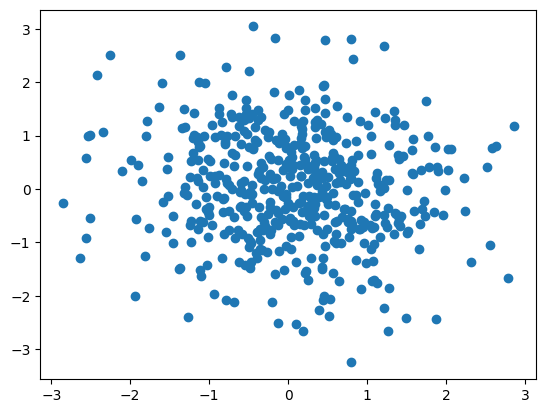

In [8]:
x = np.zeros(500)
y = np.zeros(500)
for i in range(500):
  x[i] = np.random.normal(0,1)
  y[i] = np.random.normal(0,1)
plt.scatter(x,y)

random.normal(0,1)という記述となっていますが，これは，平均0, 標準偏差1の正規分布に従う乱数を発生させるという意味です（0, 1を変化させることで乱数の性質を変えることができます）
上の例では，独立な乱数を500個ずつ発生させ，それをグラフとして表示しています．正規分布に近い形の分布が得られていることがわかります．

関数は，よく使う計算・機能をよびだしやすい形で定義しておくものです．ここでは$x^2$を実現する関数を定義してみます．


In [9]:
def sqr(x):
  answer = x * x
  return answer

print(sqr(2))

4


上の例では，sqrという関数を定義し，その中でxの2乗の計算が行われています．計算結果は answer に代入され，これを return することで，sqr(x) のように記述することで2乗の計算を実現できます．数式でよく利用される$f(x)$を定義しているものと考えてください．

以上を踏まえて本題です．

# 1. 計測データの作成
まず，バネの計測データを作成します．実際に計測を行うと大変なため，コンピュータ上で仮想的に計測データを作成します．

今回は重さが10gから50gまでの分銅が無数にあるとして，それぞれの重さの分銅を吊るした場合のバネの長さを計測してみます．ただし，長さを正確に計測するための定規を準備することができなかったため，長さの計測は目測で行うものとします．また，目測による計測誤差は正規分布に従うものとします．

まず，重さ$x$のおもりをバネに吊るした場合のバネの長さは以下の式で表されます．

$y = k x + c$

$k$はバネ定数，$c$は0gのおもりを吊るした場合のバネの長さです．今回はこのバネ定数$k$と長さ$c$の両方がわからないものとして，この２つの推定を行います．

最初に書いたとおり，バネの計測結果は計測誤差を含みますので，計測により得られるバネの長さは以下のように表現できます．

$y_i = k x_i + c_i + \epsilon_i,\ \  \epsilon_i \sim {\cal N}(0,\sigma^2)$

$\sigma$は誤差の標準偏差です．この$\sigma$についても未知であるものとします．

まずは，この計測モデルに従って$N$回分の計測データを作成します．

## 問題1
変数 k, c また，誤差の標準偏差 sigma にある値が設定されているとし，下のプログラムの抜けている箇所を完成させて$N$個の計測結果を作成しなさい．
#[重要] プログラムを実行するためには下の[初期設定]が必要となるため，必ず最初に実行（左の▶ボタンを押下）しておくこと

In [2]:
#@title [初期設定]，この中でk, c, sigma の答えが設定されています．まずは中身をみないで進めましょう（左のボタンで実行してください）
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D

k_ans = 3
c_ans = 2
sigma = 0.1

k = k_ans
c = c_ans


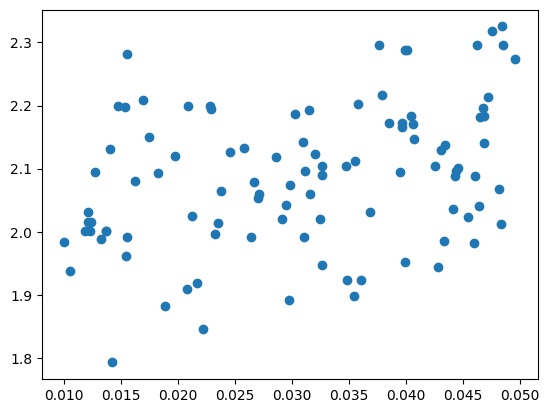

In [7]:
k = k_ans # k の値を設定
c = c_ans # c の値を設定

N = 100 #　計測回数，とりあえず100回計測する

weight = np.zeros(N) # おもりの重さを保存しておく配列の初期化，あらかじめN個のデータを保存する場所を確保
length = np.zeros(N) # 計測された長さを保存しておく配列の初期化

for i in range(N): # N回の繰り返し処理を行うための記述，iが 0からN-1まで順番に変化し，その間以下の命令が実行される
  # 0.01 kg から 0.05 kg までの数字をランダムに発生させる（rand.random()が0 から 1 までの数字を発生させるので，それを0.4 倍して 0.1 足す
  omori = random.random() * 0.04 + 0.01
  # 問題１：ばねの特性 k, c にある値が設定されているので，その特性と重さ omori を用いて計測結果を作成せよ．
  # 下記には epsilon_i となる乱数 np.random.normal(0,sigma) を予め記述してある．これにバネの長さを追加して完成させよ．
  nagasa =  np.random.normal(0,sigma) + k*omori + c
  weight[i] = omori # weight の i 番目に今回のおもりの重さを追加
  length[i] = nagasa# length の i 番目に今回の計測結果を追加

# 計測結果をグラフとして表示
plt.scatter(weight, length)

# 2. $k$, $c$に対する尤度の計算
次に，与えられた計測結果から，あるバネ定数$k$と長さ$c$に関する尤度を計算してみます．尤度の計算は以下の式により行われます．

$L(k, c) = \Pi_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2 }} \exp(-\frac{(y_i-(kx_i + c))^2}{2\sigma^2})$

今回，$\sigma$はわからないため，このままでは尤度を計算することができません．そのため，この式を以下のように書き換えます．

$L(k, c) = \Pi_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2 }} \exp(-\frac{1}{2\sigma^2}) \exp(-(y_i-(kx_i + c))^2) $

すべてのデータで$\sigma$は同一の値であることから，$\frac{1}{\sqrt{2 \pi \sigma^2 }} \exp(-\frac{1}{2\sigma^2})$は定数となります．これにより，この式は以下のように書き換えられます．

$L(k, c) =  C \Pi_{i=1}^N \exp(-(y_i-(kx_i + c))^2)$

ここで，$C=(\frac{1}{\sqrt{2 \pi \sigma^2 }} \exp(-\frac{1}{2\sigma^2}))^N$です．$C$は定数であるため，この値が変化しても尤度の大小関係は変化しません．したがって，$\Pi_{i=1}^N \exp(-(y_i-(kx_i + c))^2)$を最大とする$k, c$を見つけることができれば，それが尤度を最大化する$k$, $c$となります．

そのため，ここではこの$\Pi_{i=1}^N \exp(-(y_i-(kx_i + c))^2)$を尤度として計算します．
この計算は何度も記述する必要がありますので，関数 L という形で定義しておきます．

### 問題２：尤度の計算を行う関数Lを完成させなさい．

In [8]:
def L(k, c, weight, length, data_num):
  l = 1
  for i in range(0,data_num,1): # 繰り返し処理によりΠ計算を実現
    # 問題２：上記の式に従いlの値を繰り返し更新し尤度を計算できるように記述を行え
    # 下の例は， おもりの重さ x_i と 長さ，y_i の差分を順次掛けあわせていくものである．削除して適切に変更せよ
    l *= np.exp((-1)*(length[i]-(k*weight[i] + c))**2)
  return l

# $k$, $c$を変化させた場合の尤度の計算

先ほどの$L$の定義により，$k$, $c$が与えられれば，その確からしさ（尤度）を計算することができるようになりました．正しい，$k$, $c$を計算するためには，この尤度を最大とする$\hat{k}$, $\hat{c}$を求める必要があります．この推定方法には様々な方法がありますが，今回は$k$, $c$の値を少しずつ変化させて，その数値の中から尤度が最大となるものを探索してみます（このような方法をグリッドサーチと呼びます）．今回は$0<k<5$, $0<c<5$であると仮定し，この範囲で数値を0.2ずつ変化させながら，それぞれの値における尤度を計算してみます．

※この方法は，あまり賢いやり方とはいえません．

### 問題３：下のプログラムはk,cの値を少しずつ変えながらその値に対応する尤度を計算するものである．空欄を埋めることでそれぞれの k, c の値に対する尤度を計算できるようにせよ（問題２で作成した関数を利用すること）．

In [10]:
L_set = np.array([]) # 尤度を保存しておくための配列
L_max = 0 # 尤度の最大値を保存しておく変数
k_max = 0 # 尤度が最大の場合のkを保存しておく変数
c_max = 0 # 尤度が最大の場合のcを保存しておく変数
step = 0.2 # 値の更新幅，今回は0.2ずつ変化させる

for k in np.arange(0,10,step): # 0からスタートして，0.2ずつ値を増加させる
  for c in np.arange(0,10,step): # 上と同様
    yudo =  L(k, c, weight, length, N)# 問題３：先ほど定義した関数L を用いて与えられたk,cに対する尤度を計算せよ
    L_set = np.append(L_set, yudo) # 計算した尤度を保存
    if L_max < yudo: # 得られた尤度現在までに計算された尤度で最も大きければ，k_max, c_maxを更新
      L_max = yudo
      k_max = k
      c_max = c
print("k = %f, c = %f, L = %e" % (k_max, c_max, L_max))

k = 2.800000, c = 2.000000, L = 3.310693e-01


# グラフの表示

ひとまず，尤度を最大とする$k$, $c$を求めることができました．では，次に先ほど求めた尤度が$k$, $c$の値によってどのように変化したか，グラフとして表示してみましょう．

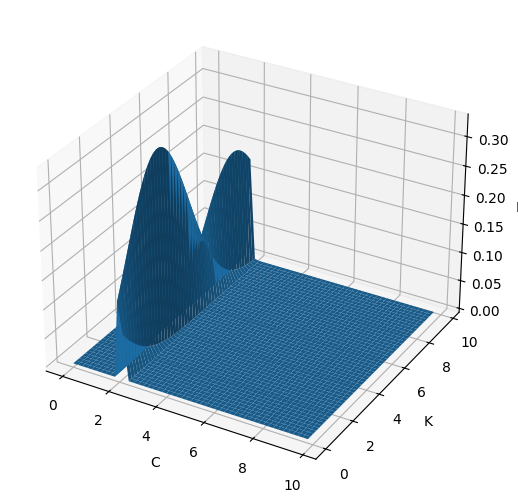

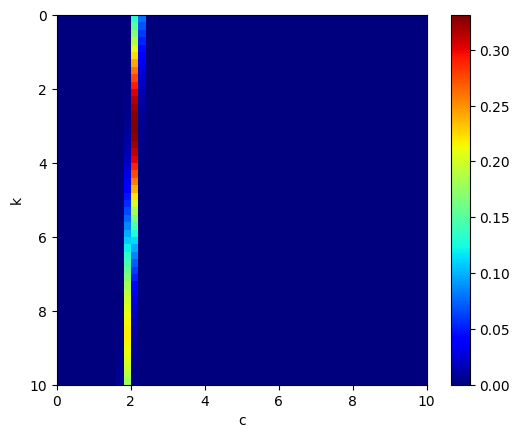

In [11]:
#@title 尤度のグラフを表示（詳細はちょっと複雑なので説明は割愛，左のボタンを押してください） { display-mode: "form" }
%matplotlib inline
L_set2 = L_set.reshape([int(10/step),int(10/step)])

x_set = np.array([[ i for i in np.arange(0,10,step)] for j in np.arange(0,10,step)])
y_set = np.array([[ j for i in np.arange(0,10,step)] for j in np.arange(0,10,step)])

fig = plt.figure()

ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

ax.set_xlabel("C")
ax.set_ylabel("K")
ax.set_zlabel("L")
ax.plot_surface(np.array(x_set),np.array(y_set),np.array(L_set2))

fig = plt.figure()
plt.imshow(L_set2,interpolation='nearest',cmap='jet',aspect=1,alpha=1, extent=[0,10,10,0]) # aspectで縦横比を調整
plt.xlabel("c")
plt.ylabel("k")

plt.colorbar()


このグラフからも，求められた$k$, $c$の値をピークとして，尤度の値が減少していることがわかります．この結果から，0.2 刻みでそれぞれの値を変化させた場合に尤度を最大とする$k$, $c$を求めることができました．

しかし，当然$k$, $c$の値は連続的に変化しているため，この値が本当に尤度を最大化しているとは限りません．そこで，最小２乗法を使って$k$, $c$を求めてみます．

# 3. 最小２乗解の推定

バネのモデル式は，以下のように書き換えることができます．

$y = k x + c =
\left [ \begin{array}{cc} x & 1 \end{array} \right ]
\left [ \begin{array}{c} k \\ c \end{array} \right ]
$

ここで，$N$回の計測が行われているとすると，以下の式が得られます

$
\left [
  \begin{array}{c} y_1  \\  \vdots \\ y_N \end{array}
\right ] =
\left [
  \begin{array}{c} x_1 \ \  1 \\  \vdots \\ x_N \ \  1 \end{array}
\right ]
\left [ \begin{array}{c} k \\ c \end{array} \right ]
$

これを，以下のように書き換えます．

${\bf y} = {\bf X} \beta$


7回の講義資料にあるとおり，今回の問題の最小2乗解は以下の式で計算されます．

$ {\bf \beta} = ({\bf X}^T{\bf X})^{-1}{\bf X}^T {\bf y}$

それでは，実際に計算してみましょう．

### 問題4：最小2乗法を用いてbetaを計算する以下のプログラムを完成させよ．


In [14]:
X = np.append([weight], [np.ones(N)],axis=0).T # [x_1, 1], [x_2,1] ,,,, ] の行列を作成
y = length.T; # Y の行列を作成

beta =  np.linalg.inv(X.T @ X) @ X.T @ y# 問題４：上述の最小２乗法を用いてk, c を計算
print("k = %f, c = %f" % (beta[0], beta[1])) # 表示

k = 3.395863, c = 1.981601


# 確認
求められた値の尤度が最大になっているか確認してみましょう

また，少しだけずらした値（0.01足した値）と比較してみて，本当に最大となっているかみてみましょう．

In [15]:
print("L(%f, %f) = %f"%(beta[0], beta[1],L(beta[0], beta[1], weight, length, N)))
print("L(%f, %f) = %f"%(beta[0]+0.01, beta[1]+0.01,L(beta[0]+0.01, beta[1]+0.01, weight, length, N)))


L(3.395863, 1.981601) = 0.332762
L(3.405863, 1.991601) = 0.329243


$k$, $c$の値を少し変化させただけで，尤度が小さくなっていることが確認できました．このことから，最小２乗法によって求められた$k$, $c$が極大値となっていることを確認できました．

では，実際に設定された値と見比べてみましょう．上の初期設定の部分をダブルクリックすると，k_ans, c_ans が設定されています．これが，今回実験に用いられた値です．これに近い値が求められているでしょうか？

今回は$N = 100$ の場合で試してみましたが，$N$の値を大きくすると，尤度はどのように変化するでしょうか？
実際に試してみましょう（やり方はビデオを確認）
同様に，誤差の標準偏差$\sigma$を変化させた場合はどうなるでしょうか．

以上を踏まえて，以下の内容を写真にとって提出してください．

1.  N = 100 の場合の尤度のグラフ
2.  N = 1000 の場合の尤度のグラフ
3.  $\sigma=0.01$に変化させた場合の$N=100$, $N=1000$の場合の尤度のグラフ
4. 上記のように尤度が変化した理由に関する考察（手書き）

今回の演習は以上で終了です．
